# **LGM-VIP Data Science Internship Programme**
# **Adavanced Level Task-3**
# **Name: Handwritten equation solver using CNN**

In [3]:
!apt-get install unrar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unrar is already the newest version (1:5.5.8-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [2]:
from google.colab import files
zip_file = files.upload()

Saving archive.zip to archive.zip


In [ ]:
!unzip archive.zip

In [ ]:
!unrar x data.rar

In [8]:
import numpy as np 
import pandas as pd 
import os
!ls

archive.zip  data.rar  extracted_images  sample_data


In [10]:
print(os.listdir("/content/extracted_images"))

['3', 'X', 'int', 'mu', 'gt', 'beta', 'alpha', '!', '9', 'S', 'tan', 'q', '=', 'prime', 'pi', 'y', 'lim', '0', 'ascii_124', '2', '}', 'H', 'phi', '(', 'forall', 'z', 'sigma', 'M', '[', 'pm', '5', 'N', '{', 'infty', 'theta', 'in', 'G', 'neq', 'l', 'j', 'ldots', '4', 'sum', 'o', 'R', 'Delta', 'p', 'sqrt', 'b', 'd', 'w', 'A', 'sin', 'geq', 'log', '1', ')', 'v', 'exists', 'C', '+', '6', 'times', '-', 'lt', 'forward_slash', 'lambda', 'T', 'u', 'rightarrow', 'div', 'k', 'i', 'cos', ',', ']', '7', 'gamma', '8', 'leq', 'f', 'e']


Note - Here I have uploded the Zip Version of DataSet as private Dataset

In [11]:
!pip install split-folders    # Library to split Train and valid Image sets in ImageNet style

In [18]:
import numpy as np
from tqdm import tqdm
from fastai import *
import torch
from fastai.vision import *
%matplotlib inline
from fastai.callbacks import *
import cv2
import pandas as pd
import splitfolders
from torchvision import transforms
import random

In [13]:
image_load_size = 64
bs = 24

In [16]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True    

SEED = 999
seed_everything(SEED)

In [17]:
splitfolders.ratio('/content/extracted_images', output="/content/output", seed=SEED, ratio=(.8, .2)) # default va

Copying files: 375974 files [01:16, 4920.25 files/s]


In [20]:
tfms = get_transforms(do_flip=True, flip_vert=False, max_lighting=0.1, max_zoom=1.05,
                      max_warp=0.,
                      xtra_tfms=[rand_crop(), rand_zoom(1, 1.5),
                                 symmetric_warp(magnitude=(-0.2, 0.2))])

In [21]:
data = (ImageList.from_folder(path='/content/output')
        .split_by_folder(train='train',valid='val')
        .label_from_folder()
        .transform(tfms,size = image_load_size,resize_method=ResizeMethod.SQUISH)
        .databunch(path='.',bs=bs)    
        .normalize(imagenet_stats)
)

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]


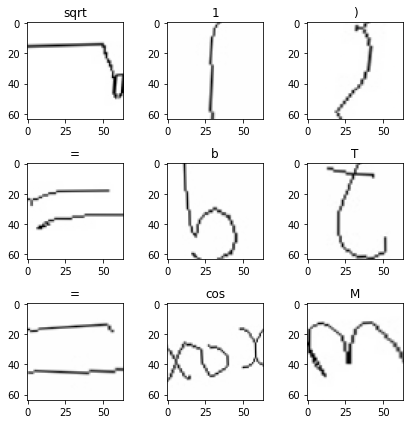

In [22]:
data.show_batch(3, figsize=(6,6), hide_axis=False)

In [23]:
len(data.classes)

82

In [ ]:
data.classes

In [25]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()

In [26]:
model = cnn_learner(data,models.densenet161, metrics = [accuracy,error_rate],callback_fns=[partial(SaveModelCallback, monitor='accuracy', name='best_model')])
model.loss_func = FocalLoss()
model.summary()

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [96, 32, 32]         14,112     False     
______________________________________________________________________
BatchNorm2d          [96, 32, 32]         192        True      
______________________________________________________________________
ReLU                 [96, 32, 32]         0          False     
______________________________________________________________________
MaxPool2d            [96, 16, 16]         0          False     
______________________________________________________________________
BatchNorm2d          [96, 16, 16]         192        True      
______________________________________________________________________
ReLU                 [96, 16, 16]         0          False     
______________________________________________________________________
Conv2d               [192, 16, 16]        18,432     False     
___________________________________________________

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-03
Min loss divided by 10: 8.32E-03


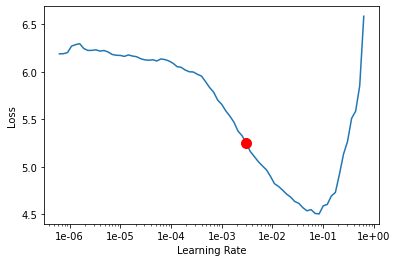

In [27]:
model.lr_find()
model.recorder.plot(suggestion = True)

In [28]:
lr = 2e-3
model.fit_one_cycle(1,slice(lr))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.260001,0.126029,0.918940,0.081060,49:51


Better model found at epoch 0 with accuracy value: 0.9189397692680359.


epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 2.29E-05


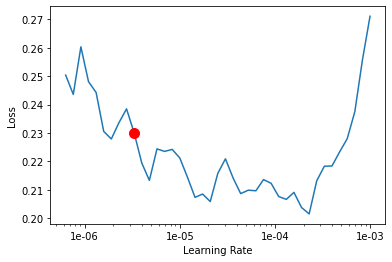

In [29]:
model.unfreeze()
model.lr_find()
model.recorder.plot(suggestion = True)

In [32]:
valid_loss_save_model,accuracy_save_model, error_rate_save_model = model.validate(model.data.valid_dl)
print('valid_loss:', valid_loss_save_model, 'accuracy:', float(accuracy_save_model),'error_rate:',float(error_rate_save_model))

valid_loss: 0.12602934 accuracy: 0.9189397692680359 error_rate: 0.0810602456331253


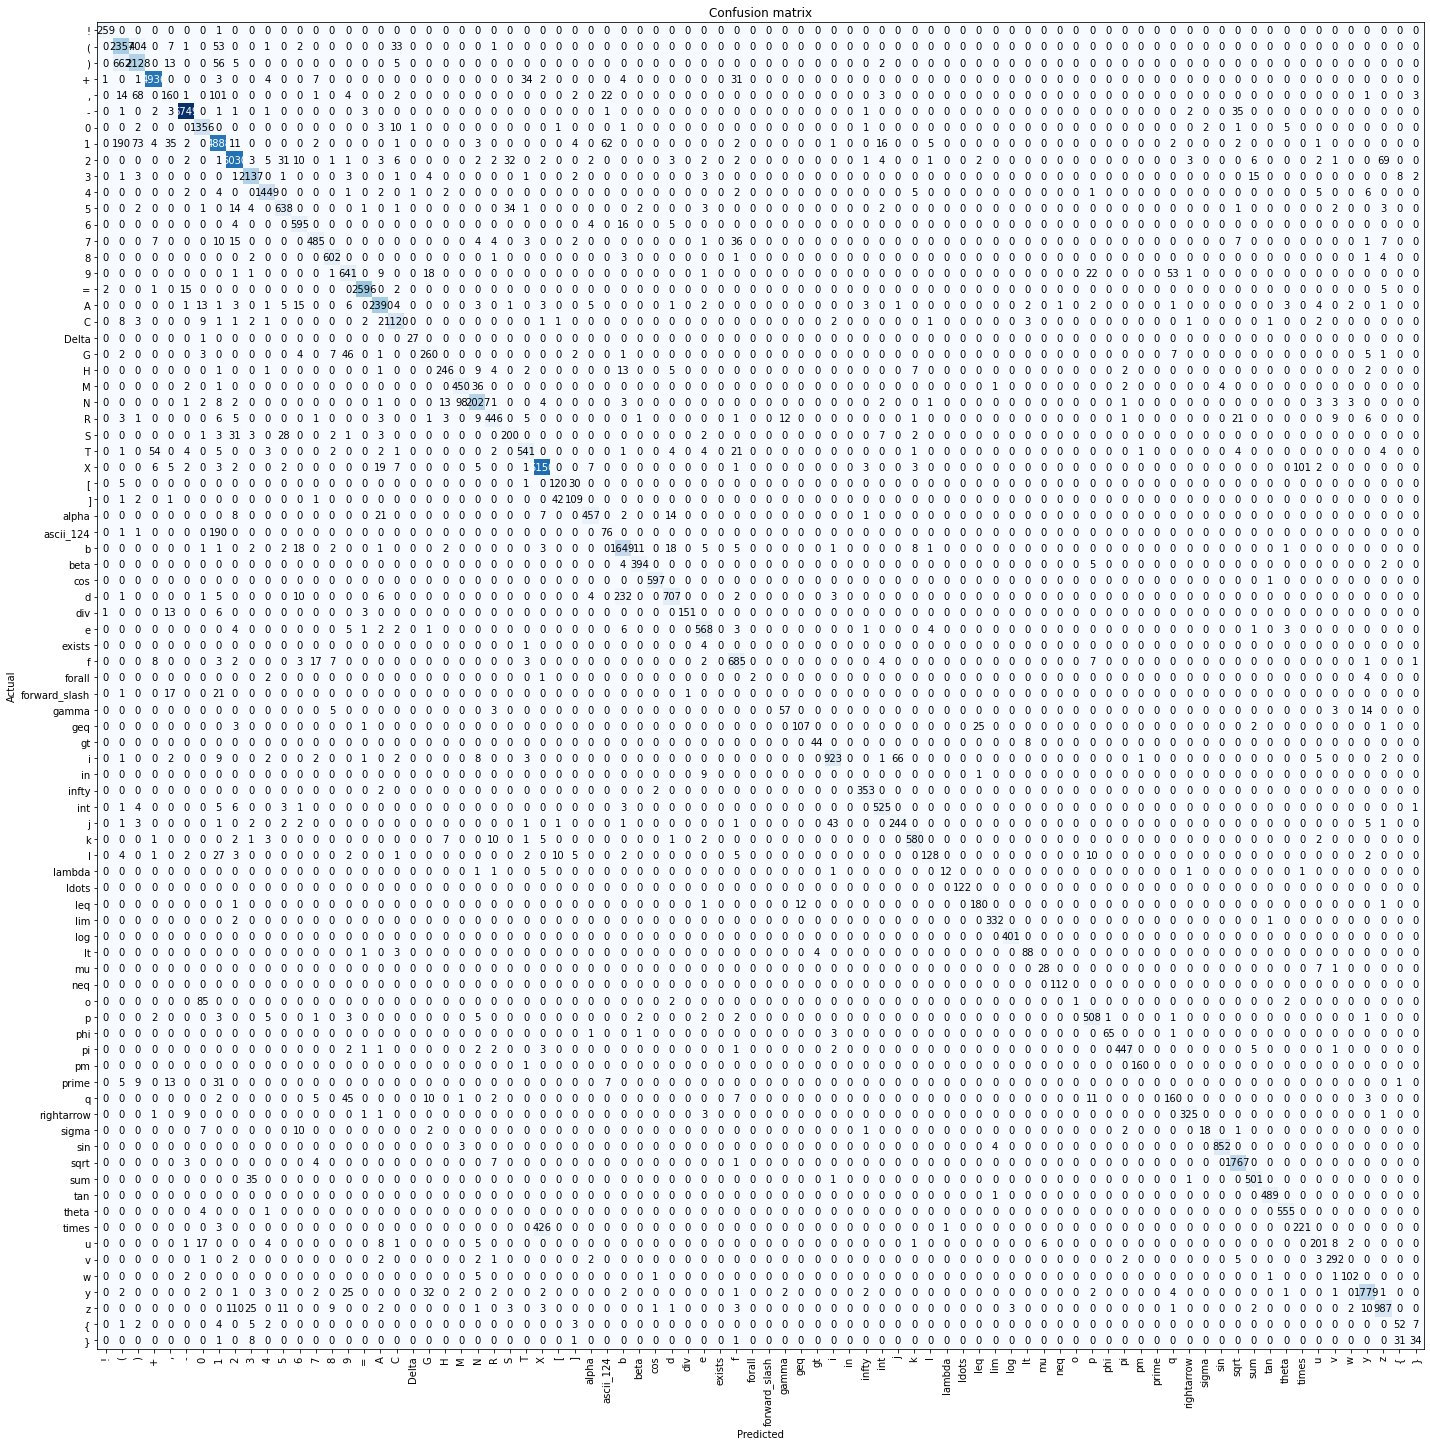

In [33]:
interpreter = ClassificationInterpretation.from_learner(model)
interpreter.plot_confusion_matrix(figsize = (20,20))

In [34]:
interpreter.most_confused(min_val=50)

[(')', '(', 662),
 ('times', 'X', 426),
 ('(', ')', 404),
 ('d', 'b', 232),
 ('1', '(', 190),
 ('ascii_124', '1', 190),
 ('z', '2', 110),
 (',', '1', 101),
 ('X', 'times', 101),
 ('N', 'M', 98),
 ('o', '0', 85),
 ('1', ')', 73),
 ('2', 'z', 69),
 (',', ')', 68),
 ('i', 'j', 66),
 ('1', 'ascii_124', 62),
 (')', '1', 56),
 ('T', '+', 54),
 ('(', '1', 53),
 ('9', 'q', 53)]

In [35]:
print(os.listdir('/content/output/val/!'))

['!_12288.jpg', 'exp88405.jpg', 'exp28667.jpg', 'exp13046.jpg', 'exp9778.jpg', 'exp27251.jpg', '!_19478.jpg', 'exp11401.jpg', 'exp19741.jpg', 'exp16055.jpg', '!_100626.jpg', 'exp20302.jpg', 'exp20531.jpg', 'exp11709.jpg', '!_7865.jpg', 'exp83309.jpg', 'exp25548.jpg', 'exp23923.jpg', 'exp17667.jpg', 'exp25037.jpg', '!_27266.jpg', '!_26132.jpg', '!_14926.jpg', '!_112938.jpg', 'exp86447.jpg', 'exp95213.jpg', 'exp23364.jpg', 'exp93080.jpg', 'exp25819.jpg', 'exp24757.jpg', 'exp16332.jpg', 'exp18672.jpg', '!_14634.jpg', '!_9957.jpg', 'exp21178.jpg', 'exp7876.jpg', 'exp8194.jpg', 'exp28646.jpg', 'exp13356.jpg', 'exp93032.jpg', 'exp20091.jpg', 'exp21835.jpg', 'exp7945.jpg', 'exp14073.jpg', '!_12585.jpg', '!_22915.jpg', 'exp7935.jpg', '!_21173.jpg', 'exp19478.jpg', 'exp26964.jpg', 'exp13603.jpg', 'exp14323.jpg', 'exp20002.jpg', 'exp15746.jpg', 'exp25284.jpg', '!_102111.jpg', 'exp8931.jpg', 'exp12288.jpg', '!_110419.jpg', '!_14347.jpg', 'exp93838.jpg', 'exp11047.jpg', '!_24385.jpg', '!_23212.jpg

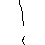

In [36]:
open_image('/content/output/val/!/!_10838.jpg')

In [37]:
pred = model.predict(open_image('/content/output/val/!/!_10838.jpg'))
print(pred[0])

!
